### CS5228 Mini Project Team 07 - Unsupervised Learning

#### Objective

This notebook aims to apply K-Means and DBSCAN clustering algorithms to group customers in the training dataset based on usage patterns.

#### Imports

In [91]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

#### Read the processed dataset

In [92]:
with open('./dataset/cleaned_datasets.pkl', 'rb') as f:
    dataests = pickle.load(f)
    
min_max_train_df = dataests['min_max_scale_pca']['train']
standard_train_df = dataests['standard_scale_pca']['train']

# Remove the Churn column
min_max_train_df = min_max_train_df.drop(columns=['Churn'])
standard_train_df = standard_train_df.drop(columns=['Churn'])

Determine the optimal number of clusters using the Elbow Method or Silhouette Score

In [93]:
def kmeans_elbow_method(data, start, step, num_steps=10, **params):
    mse_scores = []
    for i in np.arange(start, start + num_steps * step, step):
        params['n_clusters'] = i
        model = KMeans(**params)
        model.fit(data)
        mse_scores.append(model.inertia_)
    return mse_scores

def kmeans_silhouette_scores(data, start, step, num_steps=10, **params):
    silhouette_scores = []
    for i in np.arange(start, start + num_steps * step, step):
        params['n_clusters'] = i
        model = KMeans(**params)
        model.fit(data)
        silhouette_scores.append(silhouette_score(data, model.labels_))
    return silhouette_scores

def plot_results(min_max_results, standard_results, metric_name, start, step):
    num_steps = 10
    
    x_values = np.arange(start, start + num_steps * step, step)

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    
    ax[0].plot(x_values, min_max_results, marker='o')
    ax[0].set_title(f'Min-Max Scaled Data ({metric_name})')
    ax[0].set_xlabel('Number of Clusters' if 'KMeans' in metric_name else 'Epsilon (eps)')
    ax[0].set_ylabel(metric_name)
    ax[0].grid(True)

    ax[1].plot(x_values, standard_results, marker='o')
    ax[1].set_title(f'Standard Scaled Data ({metric_name})')
    ax[1].set_xlabel('Number of Clusters' if 'KMeans' in metric_name else 'Epsilon (eps)')
    ax[1].set_ylabel(metric_name)
    ax[1].grid(True)

    plt.tight_layout()
    plt.show()


#### K-means

The elbow is at around k=4 based on MSE

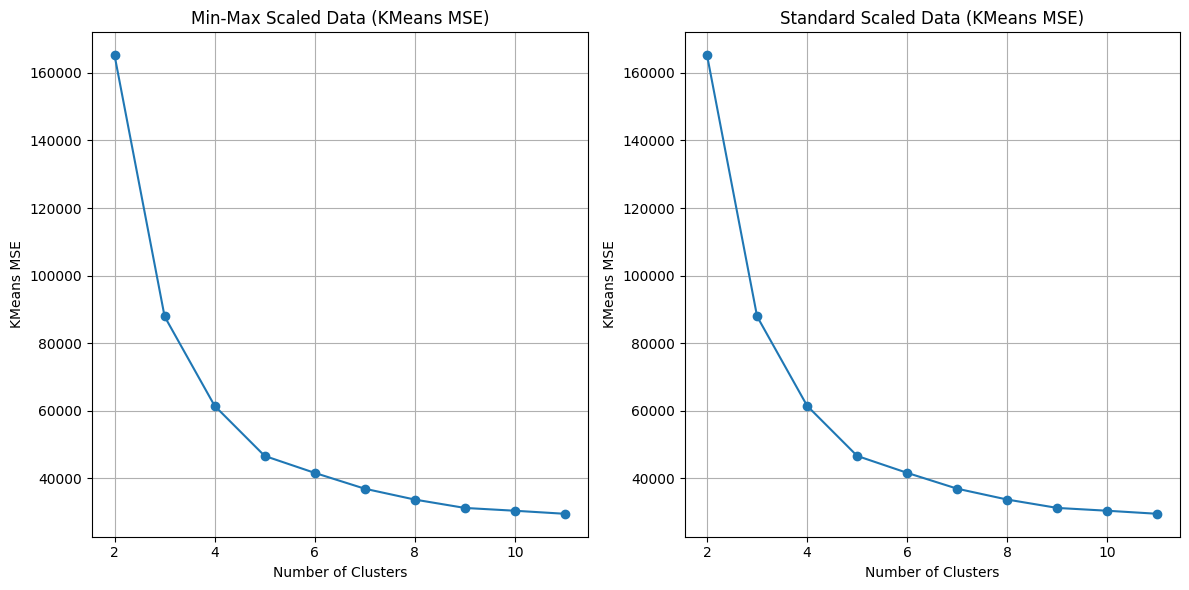

In [94]:
min_max_mse = kmeans_elbow_method(min_max_train_df, start=2, step=1, n_init='auto', init='k-means++', random_state=42)
standard_mse = kmeans_elbow_method(standard_train_df, start=2, step=1, n_init='auto', init='k-means++', random_state=42)
plot_results(min_max_mse, standard_mse, metric_name='KMeans MSE', start=2, step=1)

There is no clear peak for silhouette_score and we prefer values that are closer to 1. so k=2,3,4 may be better choices

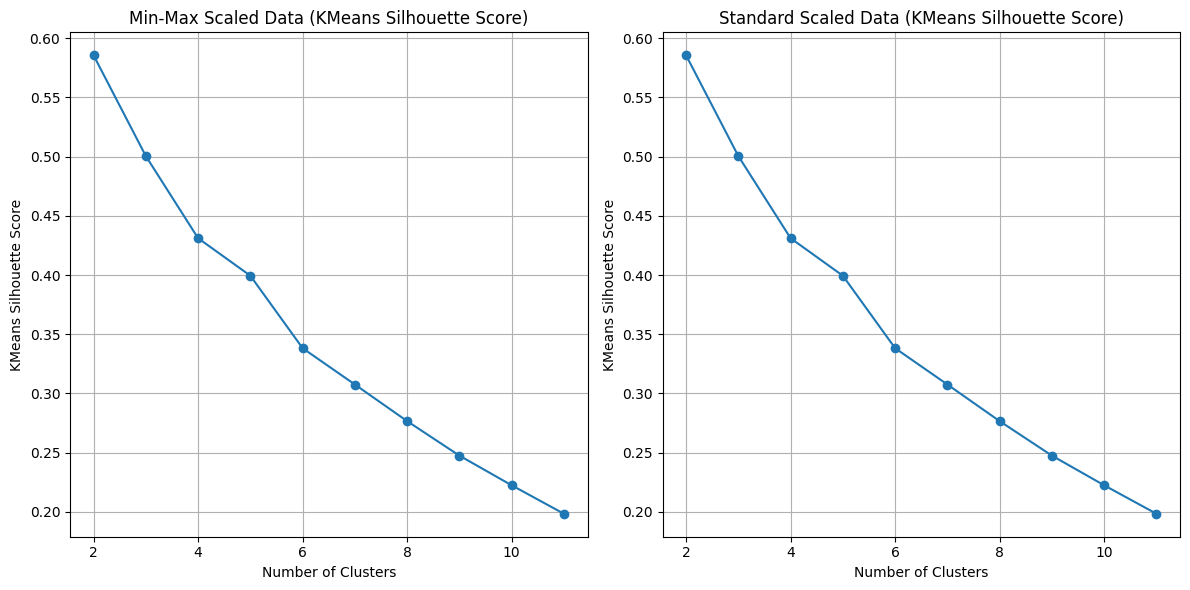

In [95]:
min_max_silhouette = kmeans_silhouette_scores(min_max_train_df, start=2, step=1, n_init='auto', init='k-means++', random_state=42)
standard_silhouette = kmeans_silhouette_scores(standard_train_df, start=2, step=1, n_init='auto', init='k-means++', random_state=42)
plot_results(min_max_silhouette, standard_silhouette, metric_name='KMeans Silhouette Score', start=2, step=1)

#### DBSCAN

In [96]:
def dbscan_silhouette_scores(data, start, step, num_steps=10, **params):
    silhouette_scores = []
    for eps in np.arange(start, start + num_steps * step, step):
        params['eps'] = eps
        model = DBSCAN(**params)
        model.fit(data)

        # Compute silhouette score only if there are at least 2 clusters
        if len(set(model.labels_)) > 1:
            silhouette_scores.append(silhouette_score(data, model.labels_))
        else:
            silhouette_scores.append(np.nan)  # Avoid errors for single clusters
    return silhouette_scores

[nan, nan, nan, -0.6604393530790937, -0.512792375140198, 0.03564218273737996, 0.05167713881443341, -0.013259939304505952, -0.12498118904619174, -0.11697905461854692] [nan, nan, nan, -0.6604393530790937, -0.512792375140198, 0.03564218273737996, 0.05167713881443341, -0.013259939304505952, -0.12498118904619174, -0.11697905461854692]


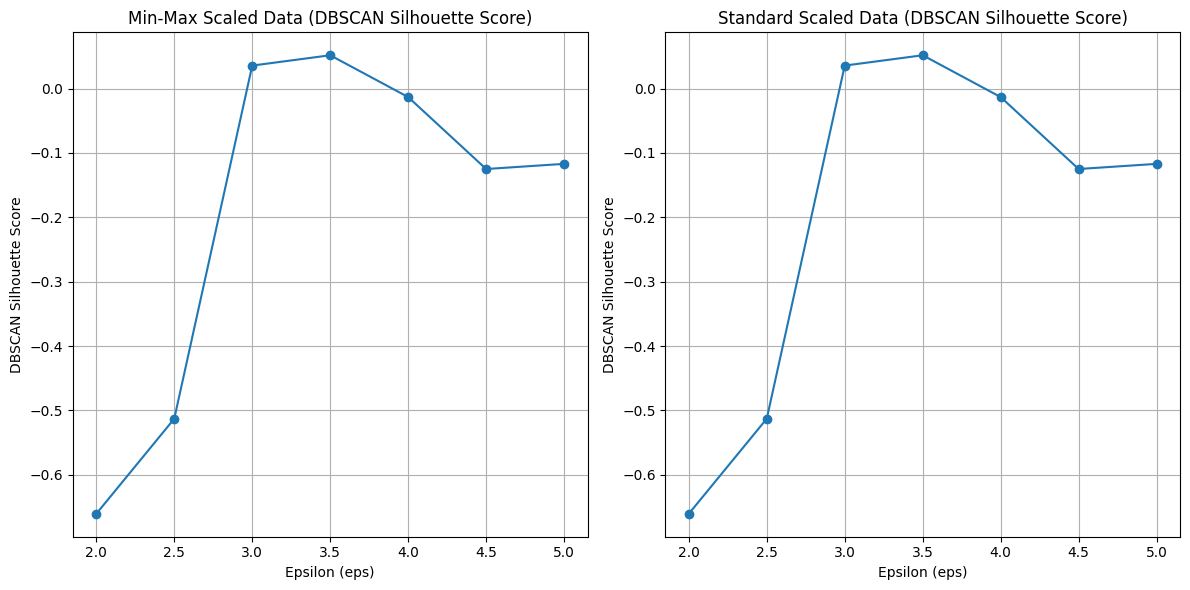

In [97]:
min_max_silhouette_dbscan = dbscan_silhouette_scores(min_max_train_df, start=0.5, step=0.5, min_samples=10)
standard_silhouette_dbscan = dbscan_silhouette_scores(standard_train_df, start=0.5, step=0.5, min_samples=10)
print(min_max_silhouette_dbscan, standard_silhouette_dbscan)
plot_results(min_max_silhouette_dbscan, standard_silhouette_dbscan, metric_name='DBSCAN Silhouette Score', start=0.5, step=0.5)